### Загрузка данных из Kaggle

In [ ]:
!pip install opendatasets requests beautifulsoup4 tqdm seaborn

In [ ]:
import os
import numpy as np
from scipy import stats
import sys
from google.colab import files
from tqdm import tqdm
import opendatasets as od
import pandas as pd
import sqlite3
import requests
from bs4 import BeautifulSoup
import seaborn as sns

In [ ]:
class KaggleDatasetLoader:
  #инициализация загрузчика
  def __init__(self, url, caloriesDataset = None):
    self.url = url
    self.calories = caloriesDataset


  #загрузка kaggle.json
  def uploadKaggleCredentials(self):
    if os.path.exists(os.path.join('kaggle.json')):
      return

    files.upload()

    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json


  #скачивание датасета
  def download(self):
    od.download(self.url)
    if self.calories:
      od.download(self.calories)


  #открытие датасета в DataFrame
  def load_to_df(self, path, preprocces = True):
    self.df = pd.read_csv(path)
    self.add_calories()
    if preprocces:
      self.preproc()


  def get_df(self):
    return self.df


  def add_calories(self):
    if self.calories:
      calories_path = "/content/povarenok/povarenok_recipes_2024_12_10.csv"
      df = pd.read_csv(calories_path)
      self.df = pd.merge(self.df, df, on=['url','name'], how='left')
      self.df['calories'] = self.df['calories'].fillna(0)


  #загрузка датасета в заранее созданную базу данных
  def load_to_db(self, table_name, db_name='database.db'):
    conn = sqlite3.connect(db_name)
    self.df.to_sql(table_name, conn, if_exists='append', index=False)


  #первичная предобработка датасета, которая делается во время открытия датасета в DataFrame
  def preproc(self, lower_indices = [-2]):
    #Удаление пустых строк
    for column in self.df:
      self.df.dropna(subset=[column], inplace=True)
    #Изменение прописных букв на строчные (по умолчанию делается в последнем столбце)
    for idx in lower_indices:
      self.df.iloc[:, idx] = self.df.iloc[:, idx].str.lower()
    if 'calories' in self.df.columns:
      self.df = self.df[self.df['calories'] != 0]
      self.df = self.df[self.df['calories'] < 2.5e4]

Создаём загрузчик датасета и загружаем kaggle.json в колаб

In [ ]:
url = "https://www.kaggle.com/datasets/rogozinushka/povarenok-recipes"
calories_url = "https://www.kaggle.com/datasets/shadrinaa/povarenok"
dataset = KaggleDatasetLoader(url, calories_url)

dataset.uploadKaggleCredentials()

Saving kaggle.json to kaggle.json


Скачиваем датасет

In [ ]:
dataset.download()

Dataset URL: https://www.kaggle.com/datasets/rogozinushka/povarenok-recipes


100%|██████████| 9.67M/9.67M [00:00<00:00, 79.6MB/s]

Dataset URL: https://www.kaggle.com/datasets/shadrinaa/povarenok


100%|██████████| 3.57M/3.57M [00:00<00:00, 119MB/s]

In [ ]:
path = "/content/povarenok-recipes/povarenok_recipes_2021_06_16.csv" #путь до скачанного датасета

dataset.load_to_df(path)

### Создание бд

Инициализация базы

In [ ]:
conn = sqlite3.connect('database.db')
#курсор позволяет отправлять запросы в базу данных
cursor = conn.cursor()

Создание таблицы с полями (столбцами):

1. url - ссылка на рецепт

2. name - название рецепта

3. ingredients - список ингредиентов и их количество

4. calories - количество ккал целого блюда

In [ ]:
#подача запроса в базу данных на создание таблицы
table_name = "RECIPES"
cursor.execute(f'''
CREATE TABLE IF NOT EXISTS {table_name} (
    url TEXT NOT NULL,
    name TEXT NOT NULL,
    ingredients TEXT NOT NULL,
    calories REAL NOT NULL
)
''')
#создадим таблицу избранных рецептов на будущее:
cursor.execute(f'''
CREATE TABLE IF NOT EXISTS FAVORITE_RECIPES (
    user_id INTEGER NOT NULL,
    url TEXT NOT NULL,
    name TEXT NOT NULL,
    PRIMARY KEY (user_id, url)
)
''')

conn.commit()

Загрузим датасет в базу данных

In [ ]:
dataset.load_to_db(table_name)

Удалим неполные рецепты

In [ ]:
cursor.execute('''
    DELETE FROM RECIPES WHERE ingredients LIKE '%none%'
''')

cursor.execute('''
  DELETE FROM RECIPES WHERE calories = 0
''')

conn.commit()

# Анализ данных

In [ ]:
import ast
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
def EDA():
  ingredient_count = countIngredients()
  make_word_cloud(ingredient_count, color_func=black_color_func)
  mostCommon(ingredient_count)
  correlateIngredients()
  caloriesDistribution()

def countRecipes():
  cursor.execute('''
  SELECT COUNT(*) FROM RECIPES
  ''')
  num = cursor.fetchall()[0][0]
  return num

def countIngredients():
  cursor.execute('''
  SELECT ingredients FROM RECIPES
  ''')
  rows = cursor.fetchall()
  ingredients = []

  for row in rows:
    ingredients_dict = ast.literal_eval(row[0])
    ingredients.extend(ingredients_dict.keys())

  ingredient_count = Counter(ingredients)

  return ingredient_count

#Введём функцию, которая возвращает чёрный цвет
def black_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "black"

def make_word_cloud(data, color_func):
  print('----------------------------')
  print('Облако ингредиентов')
  print('----------------------------')
  wordcloud = WordCloud(width=800, height=800, background_color='white', color_func=color_func).generate_from_frequencies(data)

  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

def mostCommon(data):
  print('----------------------------')
  print('Самые встречаемые ингредиенты')
  print('----------------------------')
  n = min(10, len(data))
  recipes_num = countRecipes()
  most_common = data.most_common(n)
  names, values = zip(*most_common)

  df = pd.DataFrame({'name': names, 'count': values})
  df['count'] = df['count'].div(recipes_num) * 100

  plt.figure(figsize=(10, 6))
  sns.barplot(x='count', y='name', data=df, palette='flare')
  plt.xlabel('Встречаемость, %')
  plt.ylabel('Ингредиент')
  plt.title('Топ-10 ингредиентов')
  plt.show()

def extract_ingredients(ingredient_string):
  try:
    ingredient_dict = ast.literal_eval(ingredient_string)
    return list(ingredient_dict.keys())
  except (ValueError, SyntaxError):
    return []


def correlateIngredients(n = 10):
  print('----------------------------')
  print('Корреляция ингредиентов')
  print('----------------------------')
  query = "SELECT ingredients FROM RECIPES"
  df = pd.read_sql_query(query, conn)
  df['ingredients'] = df['ingredients'].apply(extract_ingredients)
  all_ingredients = [ingredient for sublist in df['ingredients'] for ingredient in sublist]
  ingredient_counts = pd.Series(all_ingredients).value_counts()
  top_ingredients = ingredient_counts.head(n).index.tolist()
  recipes_binary = pd.DataFrame(0, index=df.index, columns=top_ingredients)
  for idx, row in df.iterrows():
    for ingredient in row['ingredients']:
        if ingredient in top_ingredients:
            recipes_binary.at[idx, ingredient] = 1
  correlation_matrix = recipes_binary.corr()
  plt.figure(figsize=(8, 6))
  sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
  plt.title(f'Корреляционная карта {n} ингредиентов')
  plt.show()

def caloriesDistribution():
  print('----------------------------')
  print('Распределение калорий')
  print('----------------------------')
  query = "SELECT calories FROM recipes"
  df = pd.read_sql_query(query, conn)
  plt.figure(figsize=(10, 6))
  sns.histplot(df['calories'], kde=False)
  plt.title('Распределение калорий')
  plt.xlabel('Калории')
  plt.ylabel('Частота')
  plt.show()

----------------------------
Облако ингредиентов
----------------------------


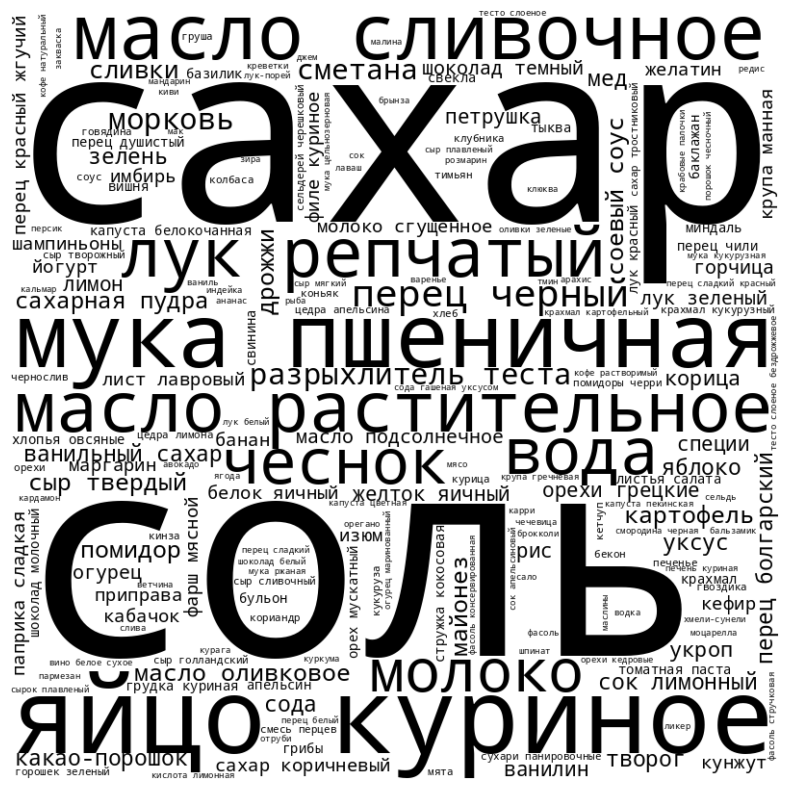

----------------------------
Самые встречаемые ингредиенты
----------------------------


<ipython-input-12-baf122541b0e>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='name', data=df, palette='flare')


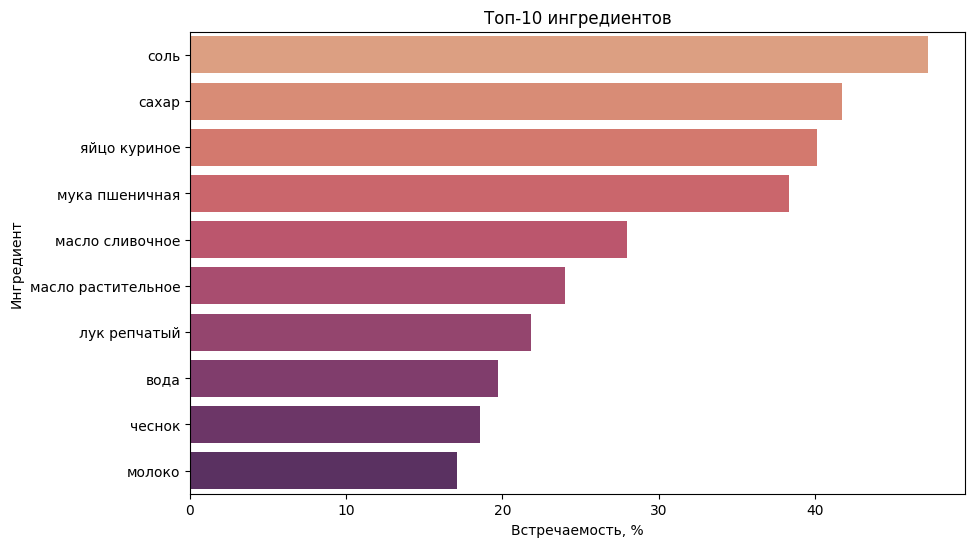

----------------------------
Корреляция ингредиентов
----------------------------


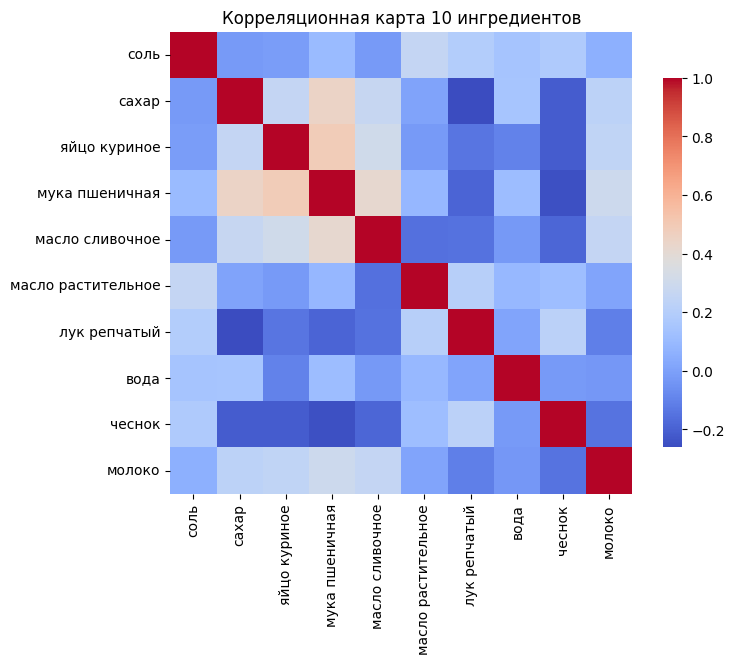

----------------------------
Распределение калорий
----------------------------


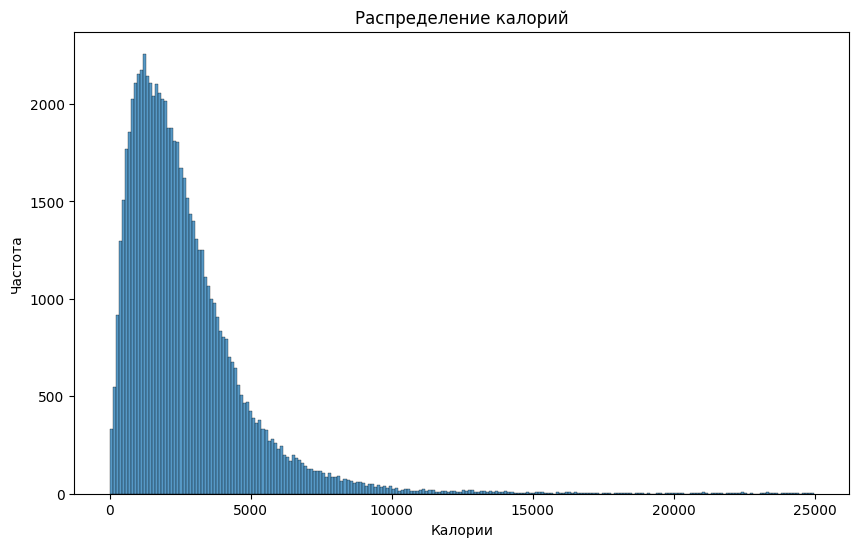

In [ ]:
EDA()

## Наблюдения

Ингредиенты
---
* Самые распространённые ингредиенты: соль, сахар, яйца, мука и масло (сливочное и растительное)
* Неудивительно, что соль и сахар стали самыми популярными ингредиентами, но любопытно, что они встречаются не во всех рецептах, а лишь в 40-45% блюд
* На корреляционной карте можно увидеть, что соль и сахар независимо добавляются в рецепты
* Сахар, яйца, мука и сливочное масло имеют умеренную корреляцию
* Чеснок и репчатый лук скорее всего (нет сильной корреляции) не добавляются вместе с мукой, сахаром, сливочным маслом и яйцами
* Значит, что рецепты с мукой, сахаром, маслом представляют собой выпечку или сладкие изделия
---
Калории
---
Распределение по калориям похоже на логнормальное распределение, проверим эту гипотезу тестами Шапиро и Колмогорова-Смирнова

In [ ]:
def kolmogorov_smirnov():
  query = "SELECT calories FROM RECIPES"
  data = pd.read_sql_query(query, conn)
  log_data = np.log(data['calories'])
  log_data = log_data[log_data > 5]
  shapiro_test = stats.shapiro(log_data)
  print(f'Shapiro-Wilk Test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}')

  ks_test = stats.kstest(log_data, 'norm', args=(np.mean(log_data), np.std(log_data)))
  print(f'K-S Test statistic: {ks_test.statistic}, p-value: {ks_test.pvalue}')

In [ ]:
kolmogorov_smirnov()

Shapiro-Wilk Test statistic: 0.9907795787915247, p-value: 1.456968295261387e-51
K-S Test statistic: 0.03800692177651799, p-value: 9.033761959933445e-90


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 71177.
  res = hypotest_fun_out(*samples, **kwds)


Из тестов видно, что распределение не логнормальное (хотя очень похожее)

В этом также можно убедиться, если построить логарифм исходной выборки:

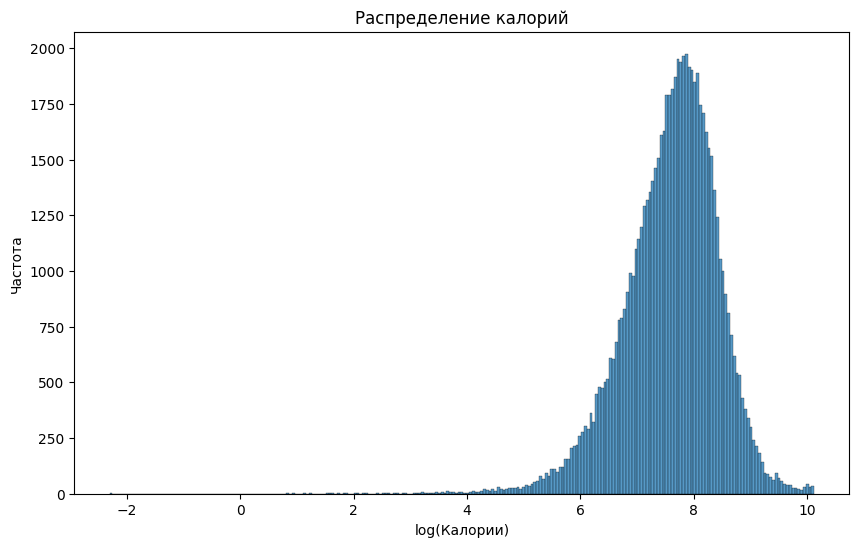

In [ ]:
query = "SELECT calories FROM recipes"
df = pd.read_sql_query(query, conn)
plt.figure(figsize=(10, 6))
sns.histplot(np.log(df['calories']), kde=False)
plt.title('Распределение калорий')
plt.xlabel('log(Калории)')
plt.ylabel('Частота')
plt.show()

Видим, что полученное распределение несимметрично и потому не похоже на нормальное